# Hector Global Climate (C++)

Here we setup, run and plot a simple global climate carbon-cycle model called [Hector](https://jgcri.github.io/hector/index.html).

Documentation can be found [here](https://jgcri.github.io/hector/articles/manual/) and [here](https://pyhector.readthedocs.io/en/latest/index.html).

In [1]:
using ClimateModels, Plots, Downloads, IniFile
using Suppressor, OrderedCollections, Git, UUIDs

import ClimateModels: build, setup

## Define Model Interface

In [2]:
"""
    struct Hector_config <: AbstractModelConfig

Concrete type of `AbstractModelConfig` for `Hector` model.
"""
Base.@kwdef struct Hector_config <: AbstractModelConfig
    model :: String = "Hector"
    configuration :: String = "hector_rcp45.ini"
    options :: OrderedDict{Any,Any} = OrderedDict{Any,Any}()
    inputs :: OrderedDict{Any,Any} = OrderedDict{Any,Any}()
    outputs :: OrderedDict{Any,Any} = OrderedDict{Any,Any}()
    status :: OrderedDict{Any,Any} = OrderedDict{Any,Any}()
    channel :: Channel{Any} = Channel{Any}(10)
    folder :: String = tempdir()
    ID :: UUID = UUIDs.uuid4()
end

Main.##267.Hector_config

In [3]:
function setup(x :: Hector_config)
    !isdir(joinpath(x.folder)) ? mkdir(joinpath(x.folder)) : nothing
    pth=joinpath(x.folder,string(x.ID))
    !isdir(pth) ? mkdir(pth) : nothing

    url="https://github.com/JGCRI/hector"
    fil=joinpath(pth,"hector")
    @suppress run(`$(git()) clone $url $fil`)

    url="https://boostorg.jfrog.io/artifactory/main/release/1.76.0/source/boost_1_76_0.tar.bz2"
    fil=joinpath(pth,"boost_1_76_0.tar.bz2")
    Downloads.download(url,fil)
    @suppress run(`tar xvf $fil -C $pth`)

    !isdir(joinpath(pth,"log")) ? git_log_init(x) : nothing

    put!(x.channel,Hector_launch)
end

setup (generic function with 2 methods)

In [4]:
function build(x :: Hector_config)
    pth0=pwd()
    pth=joinpath(x.folder,string(x.ID))

    pth_hector=joinpath(pth,"hector")

    pth_boost=joinpath(pth,"boost_1_76_0")
    ENV["BOOSTROOT"] = pth_boost
    ENV["BOOSTLIB"] = joinpath(pth_boost,"stage","lib")

    cd(pth_boost)
    @suppress run(`./bootstrap.sh --with-libraries=filesystem`)
    @suppress run(`./b2`)
    @suppress run(`./bootstrap.sh --with-libraries=system`)
    @suppress run(`./b2`)

    cd(pth_hector)
    @suppress run(`make hector`)

    cd(pth0)
end

build (generic function with 2 methods)

In [5]:
function Hector_launch(x::Hector_config)
    pth0=pwd()
    pth=joinpath(x.folder,string(x.ID))
    cd(joinpath(pth,"hector"))
    config=x.configuration
    @suppress run(`./src/hector ./inst/input/$config`)
    cd(pth0)
end

Hector_launch (generic function with 1 method)

## Setup, Build, And Launch

In [6]:
MC=Hector_config()

  ID            = bd506f80-45b1-4326-a544-66f6b27231b9
  model         = Hector
  configuration = hector_rcp45.ini
  run folder    = /tmp/bd506f80-45b1-4326-a544-66f6b27231b9
  log subfolder = /tmp/bd506f80-45b1-4326-a544-66f6b27231b9/log


In [7]:
setup(MC)
build(MC)
launch(MC)

## Read Model Output And Plot

In [8]:
function plot(x::Hector_config,varname="tgav")
    varname !=="tgav" ? println("case not implemented yet") : nothing

    pth=joinpath(x.folder,string(x.ID))
    log=readlines(joinpath(pth,"hector","logs","temperature.log"))

    ii=findall([occursin("DEBUG:run:  tgav",i) for i in log])
    nt=length(ii)
    tgav=zeros(nt)
    year=zeros(nt)

    for i in 1:nt
        tmp=split(log[ii[i]],"=")[2]
        tgav[i]=parse(Float64,split(tmp,"degC")[1])
        year[i]=parse(Float64,split(tmp,"in")[2])
    end

    f=Plots.plot(year,tgav,label=x.configuration,legend = :topleft)
    xlabel!("year"); ylabel!("degree C");
    title!("global atmospheric temperature anomaly")

    f
end

plot (generic function with 2 methods)

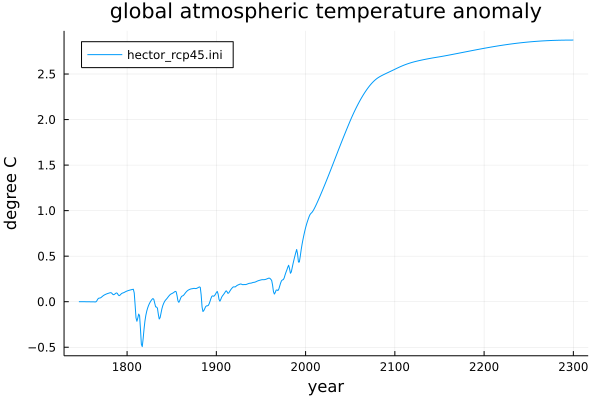

In [9]:
plot(MC,"tgav")

## Model Parameters

In [10]:
pth=joinpath(MC.folder,string(MC.ID))
fil=joinpath(pth,"hector/inst/input/",MC.configuration)

nml=read(Inifile(), fil)
nml.sections["oc"]

Dict{AbstractString, Union{Nothing, AbstractString, Number}} with 1 entry:
  "OC_emissions" => "csv:emissions/RCP45_emissions.csv"

_See run folder for workflow output:_

In [11]:
show(MC)

  ID            = bd506f80-45b1-4326-a544-66f6b27231b9
  model         = Hector
  configuration = hector_rcp45.ini
  run folder    = /tmp/bd506f80-45b1-4326-a544-66f6b27231b9
  log subfolder = /tmp/bd506f80-45b1-4326-a544-66f6b27231b9/log


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*